#### Importar librerías para el análisis y la limpieza de datos

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

#### Cargar el csv y empezar a explorar los datos

In [15]:
df = pd.read_csv('../data/raw_data/Phising_Detection_Dataset.csv')

In [16]:
df.head()

,Unnamed: 0,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
0,0,3,72,0,0,0,0,5,44,0,1.0
1,1,3,144,0,0,0,0,3,16,41,1.0
2,2,3,58,0,0,0,0,2,24,0,1.0
3,3,3,79,1,0,0,0,6,50,0,1.0
4,4,3,46,0,0,0,0,4,29,2,1.0


In [17]:
df.drop(columns='Unnamed: 0', inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662591 entries, 0 to 662590
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   NumDots          662591 non-null  int64  
 1   UrlLength        662591 non-null  int64  
 2   NumDash          662591 non-null  int64  
 3   AtSymbol         662591 non-null  int64  
 4   IpAddress        662591 non-null  int64  
 5   HttpsInHostname  662591 non-null  int64  
 6   PathLevel        662591 non-null  int64  
 7   PathLength       662591 non-null  int64  
 8   NumNumericChars  662591 non-null  int64  
 9   Phising          630071 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 50.6 MB


In [19]:
df.describe()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
count,662591.000000,662591.000000,662591.000000,662591.000000,662591.000000,662591.000000,662591.000000,662591.000000,662591.000000,630071.000000
mean,2.195062,60.254036,1.551831,0.002185,0.011283,0.025989,2.791045,40.996062,0.652540,0.158730
std,1.490275,44.597468,2.973611,0.053758,0.105620,0.162509,1.625727,29.722431,1.429861,0.365424
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,32.000000,0.000000,0.000000,0.000000,0.000000,2.000000,21.000000,0.000000,0.000000
50%,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,3.000000,35.000000,1.000000,0.000000
75%,3.000000,77.000000,2.000000,0.000000,0.000000,0.000000,4.000000,53.000000,1.000000,0.000000
max,42.000000,2175.000000,87.000000,10.000000,1.000000,5.000000,38.000000,2175.000000,111.000000,1.000000


In [20]:
# Faltan pocos datos, por lo que considero que la mejor solución es deshacerme de esas filas
df.dropna(inplace=True)

In [21]:
# Phishing es float por la falta de valores que había. Voy a cambiar la columna a enteros
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630071 entries, 0 to 662590
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   NumDots          630071 non-null  int64  
 1   UrlLength        630071 non-null  int64  
 2   NumDash          630071 non-null  int64  
 3   AtSymbol         630071 non-null  int64  
 4   IpAddress        630071 non-null  int64  
 5   HttpsInHostname  630071 non-null  int64  
 6   PathLevel        630071 non-null  int64  
 7   PathLength       630071 non-null  int64  
 8   NumNumericChars  630071 non-null  int64  
 9   Phising          630071 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 52.9 MB


In [23]:
df['Phising'] = df['Phising'].astype(int)

In [25]:
df['Phising'].value_counts()

# Los datos están desbalanceados

Phising
0    530060
1    100011
Name: count, dtype: int64

#### Renombrar Columnas:

In [32]:
df.rename(columns={"HttpsInHostname": "HttpsHostname", "NumNumericChars": "NumChars", 'Phising': 'Phishing'}, inplace=True)

In [33]:
df.head()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsHostname,PathLevel,PathLength,NumChars,Phishing
0,3,72,0,0,0,0,5,44,0,1
1,3,144,0,0,0,0,3,16,41,1
2,3,58,0,0,0,0,2,24,0,1
3,3,79,1,0,0,0,6,50,0,1
4,3,46,0,0,0,0,4,29,2,1


#### Primeras visualizaciones:

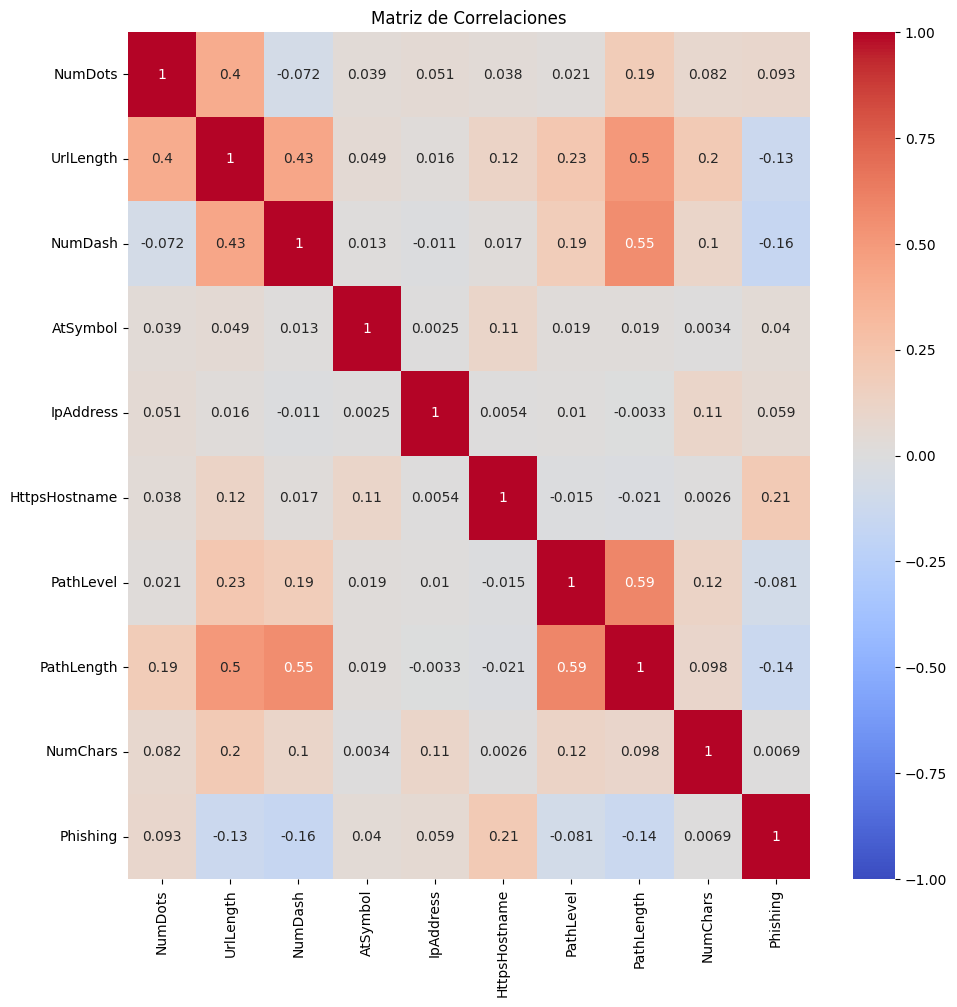

In [51]:
plt.figure(figsize=(11,11))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Matriz de Correlaciones')
plt.show();

In [53]:
# Hay correlación entre PathLevel y PathLenght. Dejaré PathLenght, que es la que más correlaciona con Phishing
df.drop(columns='PathLevel', inplace=True)

#### Voy a trabajar con una función para generar distintos DataFrames con distintos tipos de balanceo de datos y así poder evaluar cuál es el mejor

In [54]:
def balance_data(df, target_col):
    
    # Separar clases mayoritaria y minoritaria
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    # Undersampling
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,    
                                       n_samples=len(df_minority), 
                                       random_state=123)
    df_undersampled = pd.concat([df_majority_downsampled, df_minority])
    
    # Oversampling
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     
                                     n_samples=len(df_majority), 
                                     random_state=123)
    df_oversampled = pd.concat([df_majority, df_minority_upsampled])
    
    # SMOTE
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    smote = SMOTE(random_state=123)
    X_res, y_res = smote.fit_resample(X, y)
    df_smote = pd.DataFrame(X_res, columns=X.columns)
    df_smote[target_col] = y_res
    
    return {
        'undersampled': df_undersampled,
        'oversampled': df_oversampled,
        'smote': df_smote
    }

In [55]:
balanced_dataframes = balance_data(df, 'Phishing')

In [56]:
# Acceso a cada dataframe balanceado
df_undersampled = balanced_dataframes['undersampled']
df_oversampled = balanced_dataframes['oversampled']
df_smote = balanced_dataframes['smote']

In [57]:
df_undersampled.describe()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsHostname,PathLength,NumChars,Phishing
count,200022.000000,200022.000000,200022.000000,200022.000000,200022.000000,200022.00000,200022.000000,200022.000000,200022.000000
mean,2.291233,54.972038,1.146529,0.004300,0.002665,0.04215,37.715286,0.649989,0.500000
std,1.503121,45.350878,2.500055,0.073013,0.051552,0.20706,27.137016,2.226270,0.500001
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.000000,29.000000,0.000000,0.000000,0.000000,0.00000,21.000000,0.000000,0.000000
50%,2.000000,42.000000,0.000000,0.000000,0.000000,0.00000,32.000000,0.000000,0.500000
75%,3.000000,66.000000,1.000000,0.000000,0.000000,0.00000,47.000000,1.000000,1.000000
max,42.000000,1779.000000,47.000000,10.000000,1.000000,5.00000,1680.000000,111.000000,1.000000


In [58]:
df_oversampled.describe()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsHostname,PathLength,NumChars,Phishing
count,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1060120.0
mean,2.294704e+00,5.497007e+01,1.151537e+00,4.368373e-03,2.683658e-03,4.241595e-02,3.775260e+01,6.477125e-01,0.5
std,1.506229e+00,4.514713e+01,2.522461e+00,7.198109e-02,5.173450e-02,2.081445e-01,2.752479e+01,2.206687e+00,0.5
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.000000e+00,2.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+01,0.000000e+00,0.0
50%,2.000000e+00,4.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.5
75%,3.000000e+00,6.700000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,1.000000e+00,1.0
max,4.200000e+01,2.175000e+03,8.700000e+01,1.000000e+01,1.000000e+00,5.000000e+00,2.175000e+03,1.110000e+02,1.0


In [59]:
df_smote.describe()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsHostname,PathLength,NumChars,Phishing
count,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1.060120e+06,1060120.0
mean,2.269678e+00,5.492439e+01,1.130650e+00,2.630834e-03,1.850734e-03,3.212561e-02,3.772412e+01,6.347272e-01,0.5
std,1.460652e+00,4.498736e+01,2.509666e+00,5.585773e-02,4.298035e-02,1.806253e-01,2.730940e+01,2.183076e+00,0.5
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.000000e+00,2.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+01,0.000000e+00,0.0
50%,2.000000e+00,4.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.5
75%,3.000000e+00,6.700000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,1.000000e+00,1.0
max,4.200000e+01,2.175000e+03,8.700000e+01,1.000000e+01,1.000000e+00,5.000000e+00,2.175000e+03,1.110000e+02,1.0


In [50]:
# Verificación de balance
print(df_undersampled['Phishing'].value_counts())
print(df_oversampled['Phishing'].value_counts())
print(df_smote['Phishing'].value_counts())

Phishing
0    100011
1    100011
Name: count, dtype: int64
Phishing
0    530060
1    530060
Name: count, dtype: int64
Phishing
1    530060
0    530060
Name: count, dtype: int64


##### Ahora guardamos los nuevos DataFrames en processed data

In [61]:
df_undersampled.to_csv('../data/processed_data/df_undersample.csv', index=False)

In [62]:
df_oversampled.to_csv('../data/processed_data/df_oversampled.csv', index=False)

In [63]:
df_smote.to_csv('../data/processed_data/df_smote.csv', index=False)

#### Undersampling:
Continuaremos con él, será nuestro pilar para las visualizaciones y los modelos

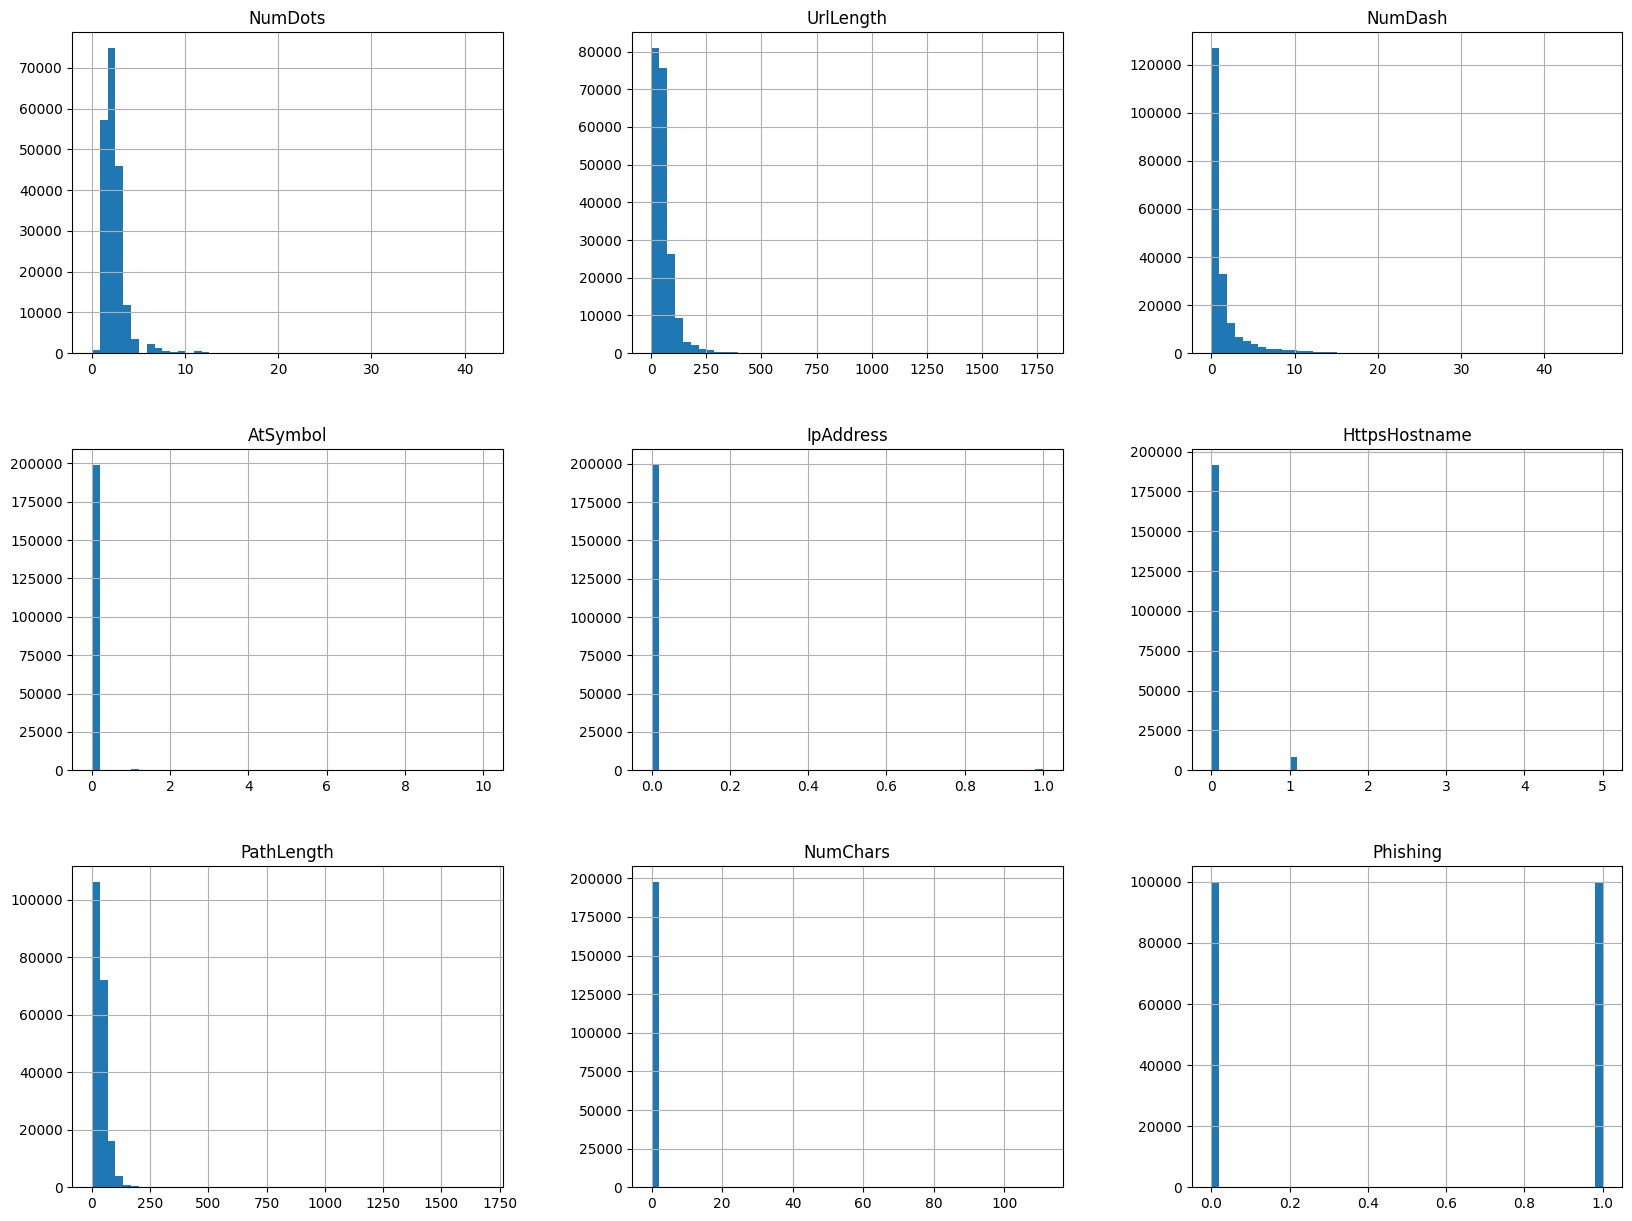

In [64]:
# Histograma para cada característica numérica
df_undersampled.hist(bins=50, figsize=(20,15))
plt.show()

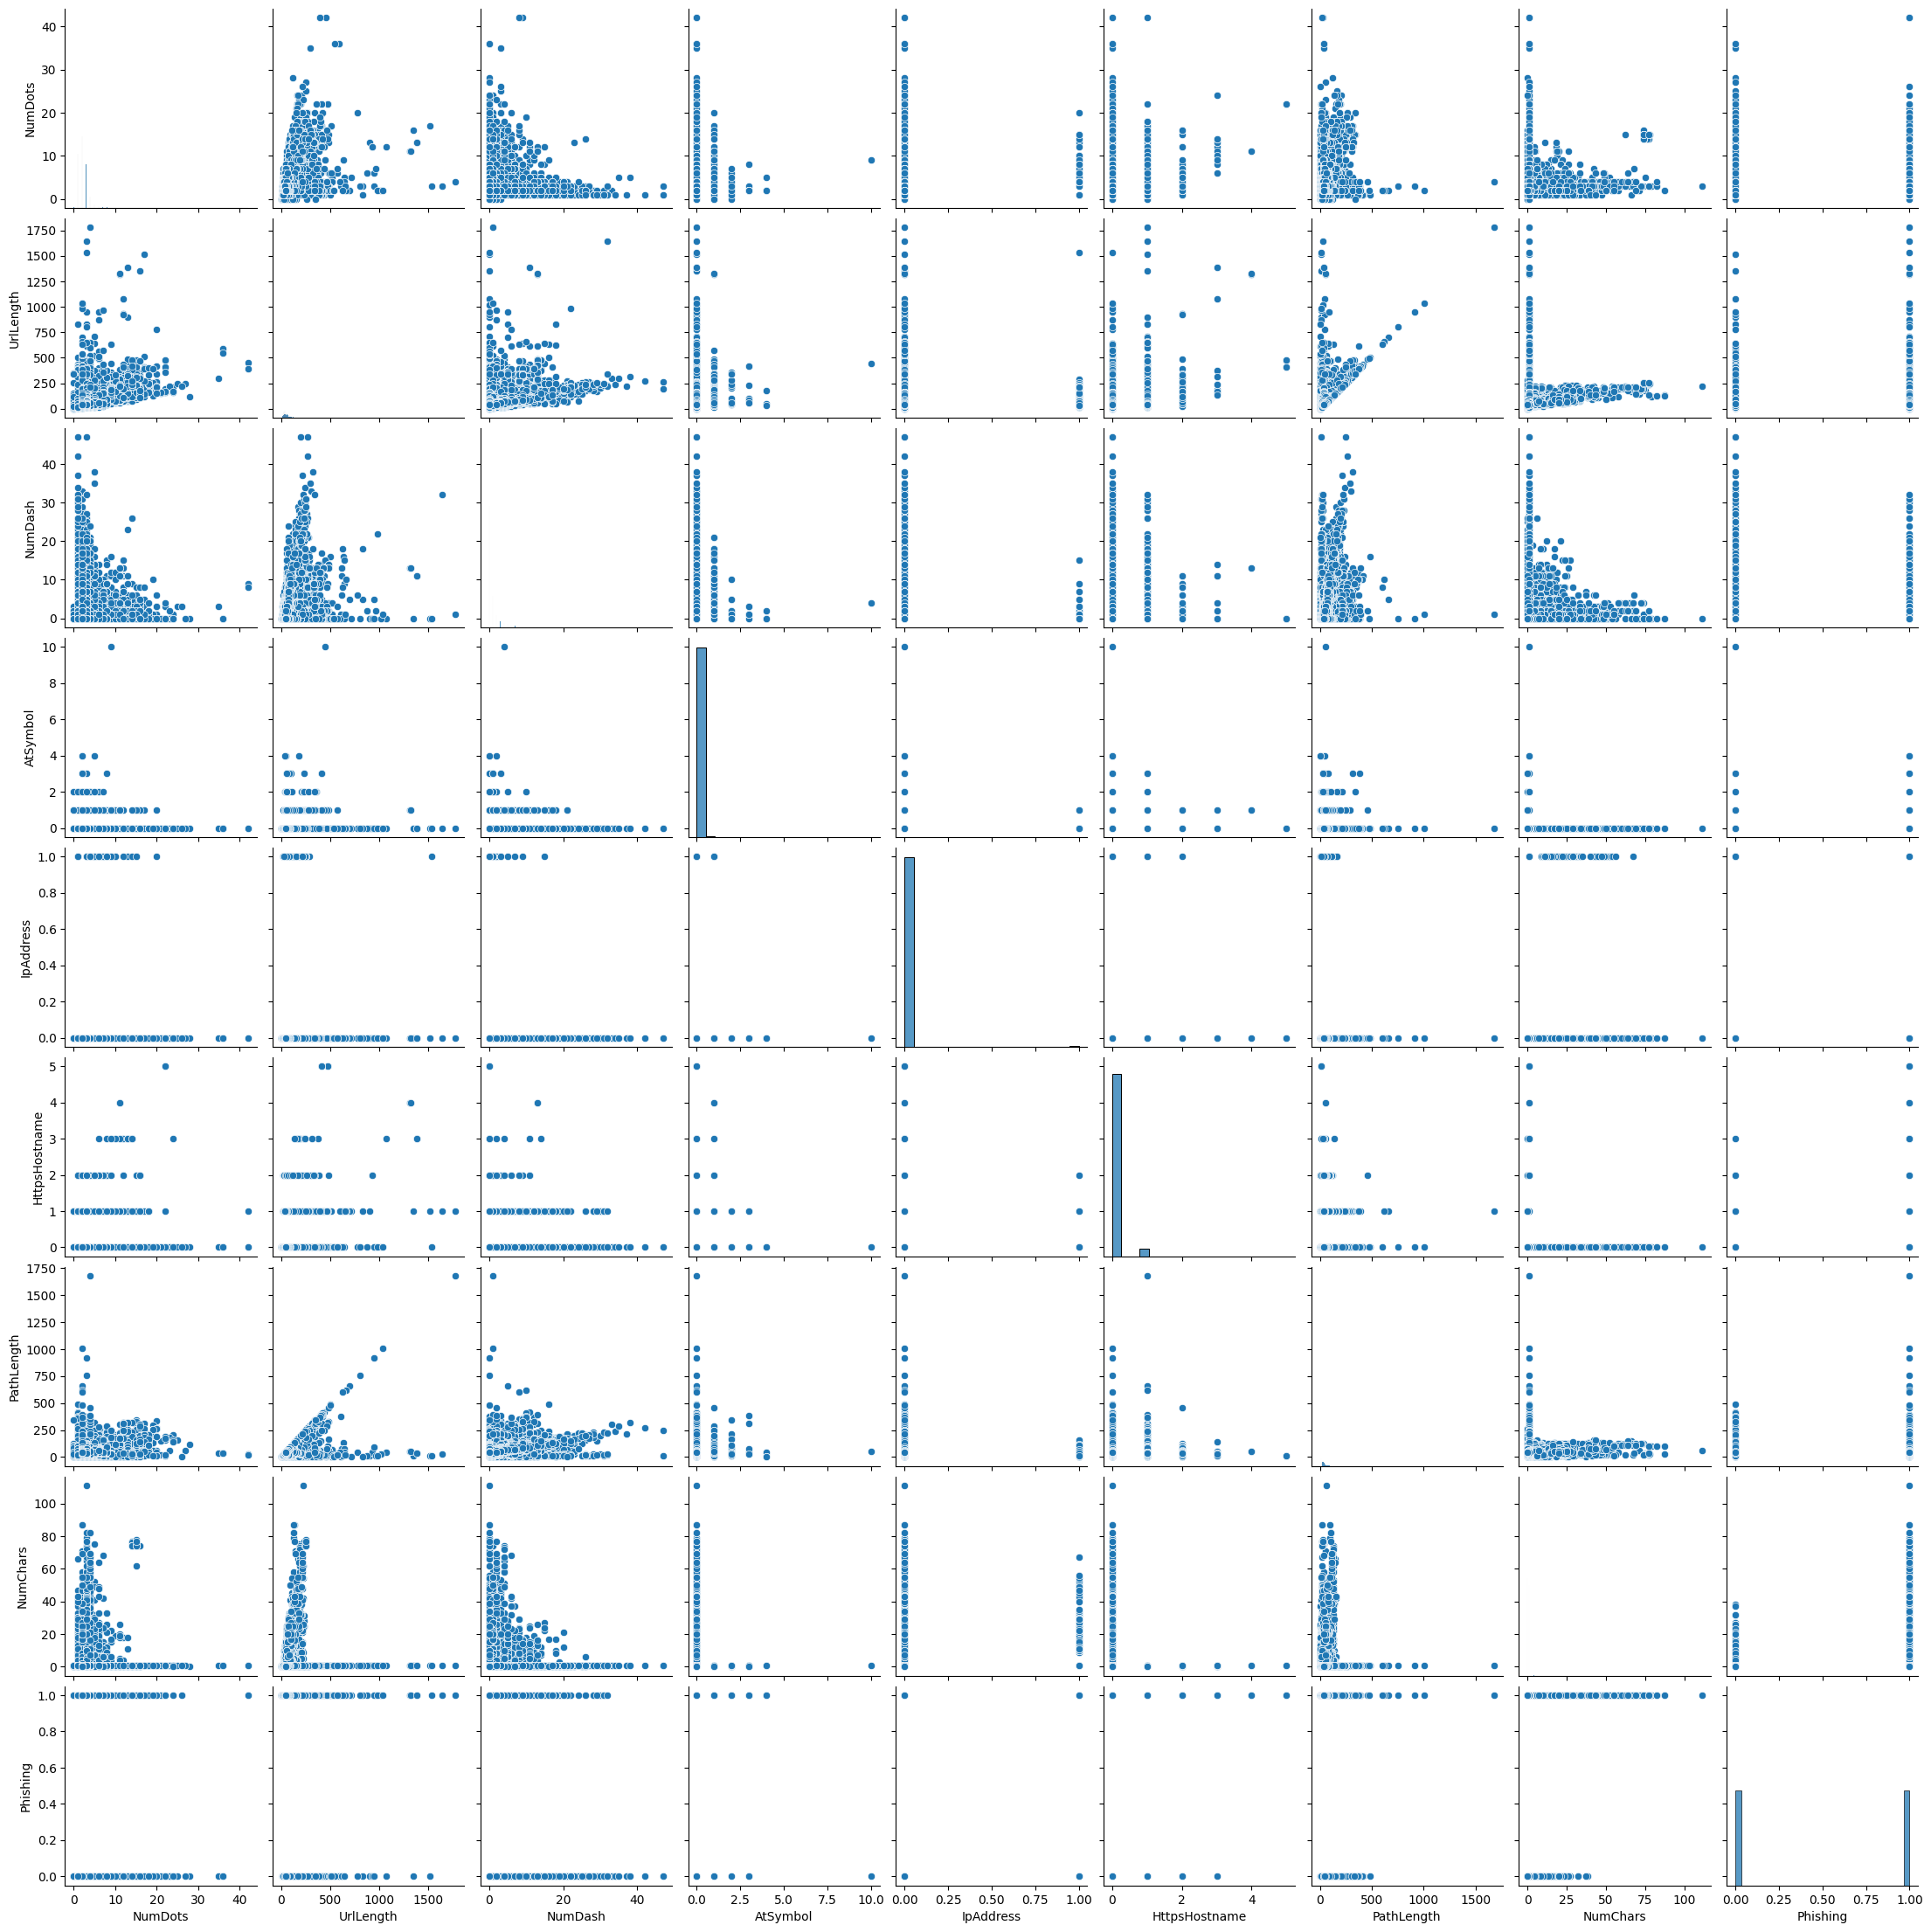

In [65]:
sns.pairplot(df_undersampled)

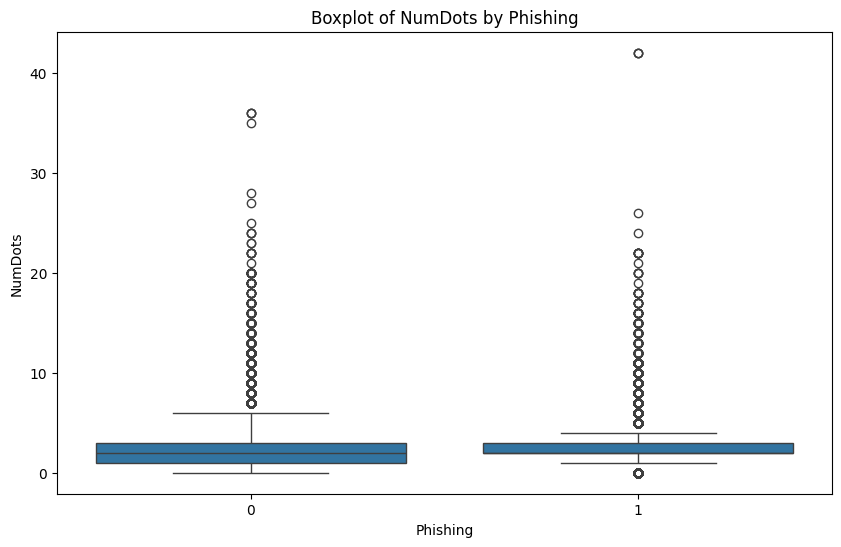

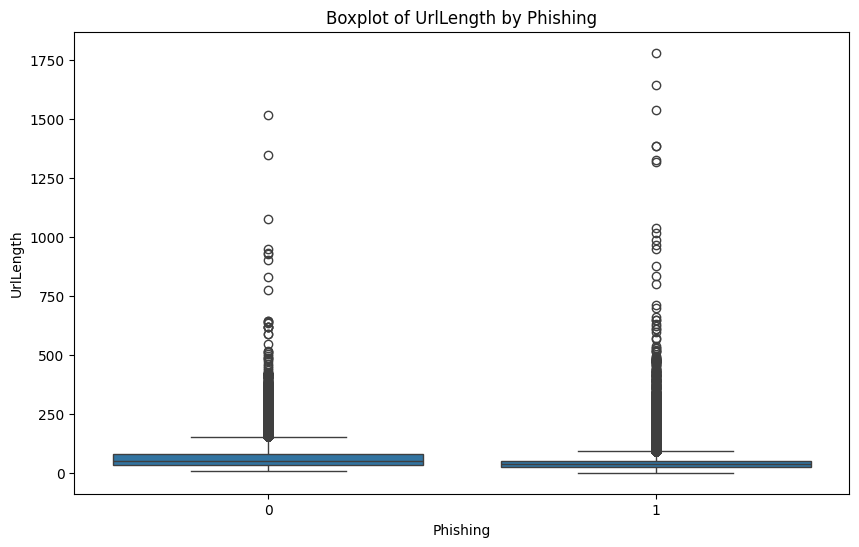

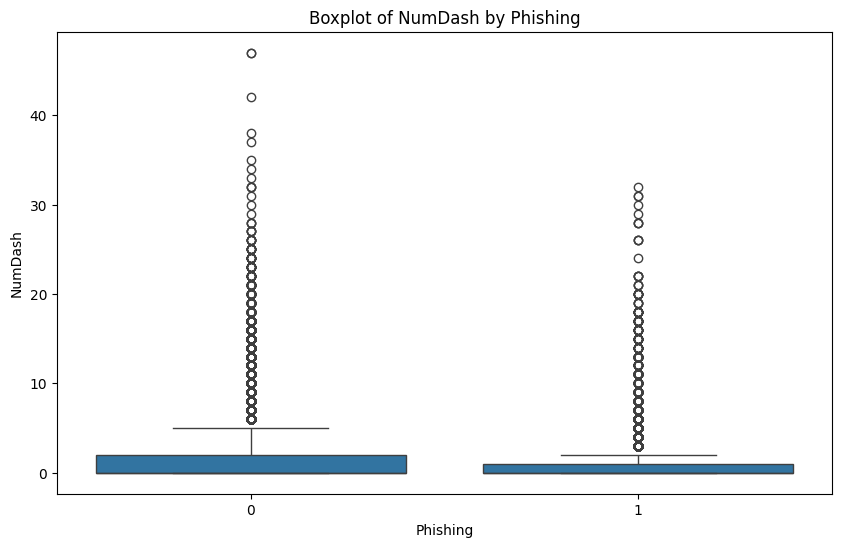

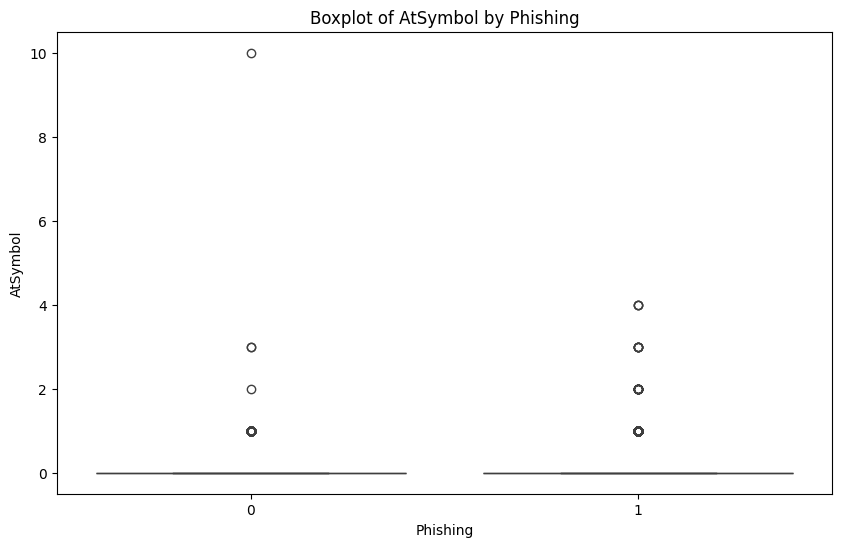

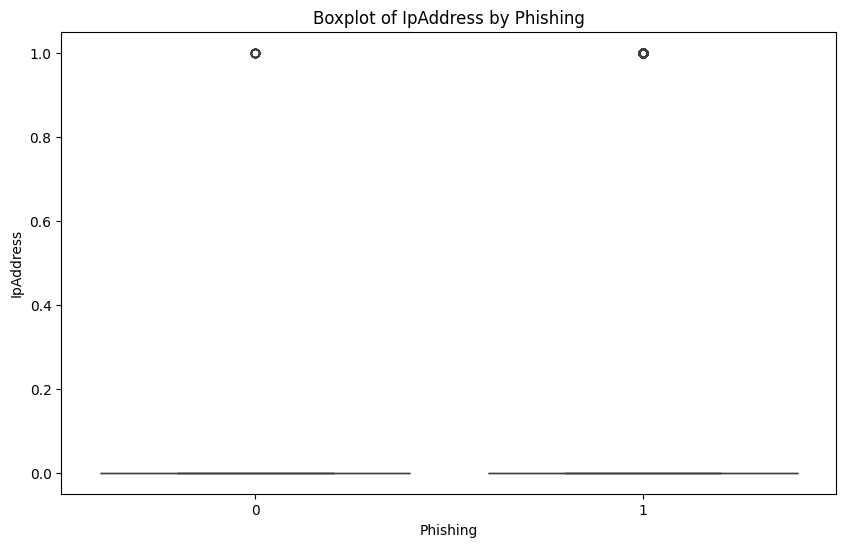

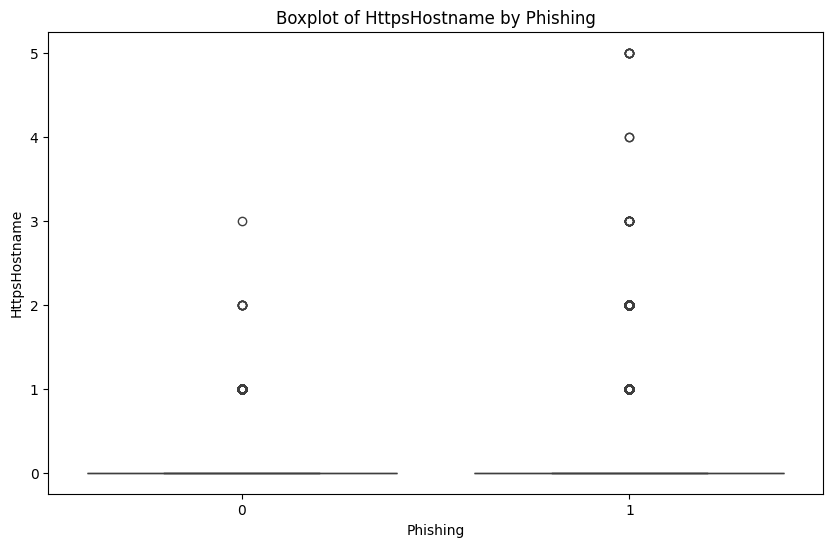

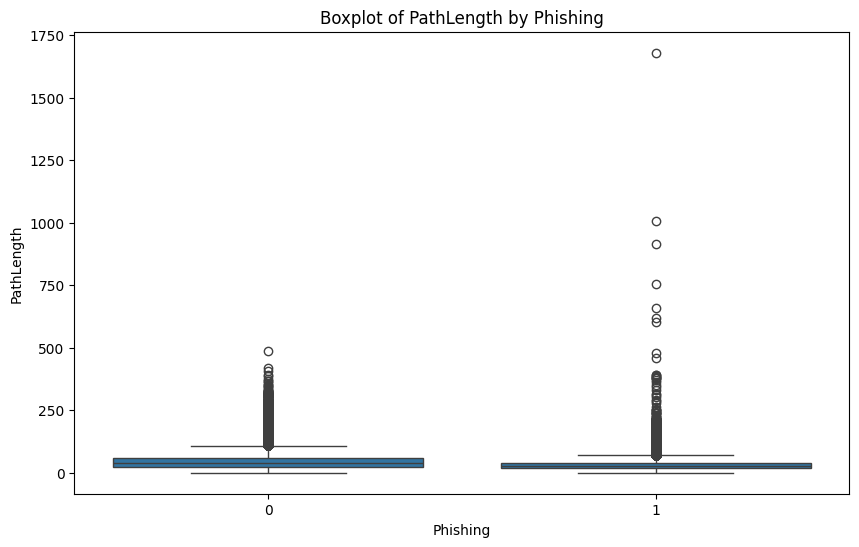

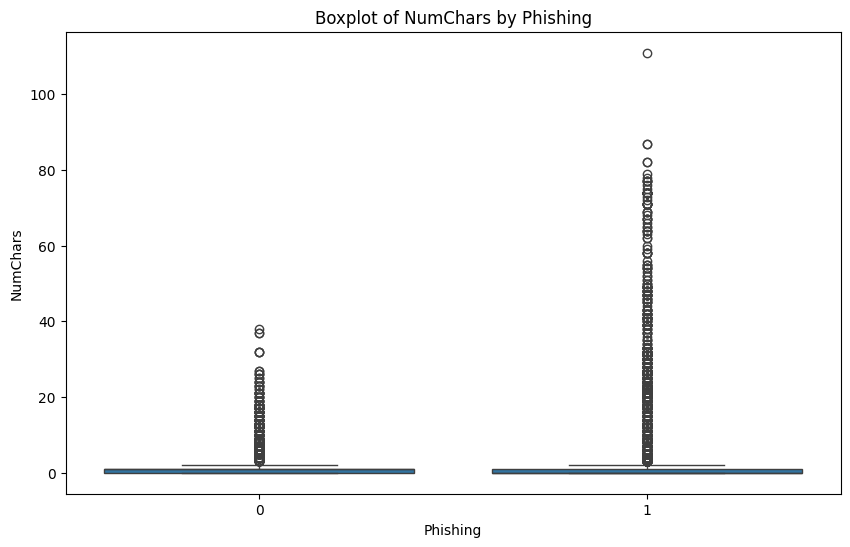

In [75]:
# Boxplot de características numéricas agrupadas por la columna 'Phishing'
for column in df_undersampled.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Phishing', y=column, data=df_undersampled)
    plt.title(f'Boxplot of {column} by Phishing')
    plt.show();

#### Generar csv para dividir en Train y Test

In [68]:
# Mezclar el dataframe
df_shuffled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Definir el tamaño del conjunto de entrenamiento
train_size = int(0.8 * len(df_shuffled))

# Dividir el dataframe en entrenamiento y prueba
df_train = df_shuffled[:train_size]
df_test = df_shuffled[train_size:]

In [69]:
# Revisemos el shape de cada uno
print(df_test.shape)
print(df_train.shape)

(40005, 9)
(160017, 9)


In [70]:
# Guardar los dataframes en archivos CSV
df_train.to_csv('../data/train/train.csv', index=False)
df_test.to_csv('../data/test/test.csv', index=False)

In [14]:
import pandas as pd
import re
from urllib.parse import urlparse

# Dada URL
url = 'https://www.kaggle.com/code/eswarchandt/website-phishing'

# Función para verificar si la URL contiene una dirección IP
def has_ip_address(url):
    ip_pattern = re.compile(r'(\d{1,3}\.){3}\d{1,3}')
    return 1 if ip_pattern.search(url) else 0

# Parsear la URL
parsed_url = urlparse(url)
hostname = parsed_url.hostname
path = parsed_url.path

# Extraer las variables
num_dots = url.count('.')
url_length = len(url)
num_dash = url.count('-')
at_symbol = 1 if '@' in url else 0
ip_address = has_ip_address(url)
https_in_hostname = 1 if 'https' in hostname else 0
path_level = path.count('/')
path_length = len(path)
num_numeric_chars = sum(c.isdigit() for c in url)
phising = 0  # Determinado manualmente, por ejemplo 0 para no phishing y 1 para phishing

# Crear un diccionario con los datos
data = {
    'NumDots': num_dots,
    'UrlLength': url_length,
    'NumDash': num_dash,
    'AtSymbol': at_symbol,
    'IpAddress': ip_address,
    'HttpsInHostname': https_in_hostname,
    'PathLevel': path_level,
    'PathLength': path_length,
    'NumNumericChars': num_numeric_chars,
    'Phising': phising
}

# Crear un dataframe
df_prueba = pd.DataFrame([data])

# Mostrar el dataframe
df_prueba

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
0,2,56,1,0,0,0,3,34,0,0
